# Exploring the trajectory of a single patient

### Import Python libraries

We first need to import some tools for working with data in Python. 
- NumPy is for working with numbers
- Pandas is for analysing data
- MatPlotLib is for making plots
- Sqlite3 to connect to the database

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

### Connect to the database

- We can use the sqlite3 library to connect to the MIMIC database
- Once the connection is established, we'll run a simple SQL query.

In [4]:
# Connect to the MIMIC database
conn = sqlite3.connect('data/mimicdata.sqlite')

In [5]:
# Create our test query
test_query = """
SELECT subject_id, hadm_id, admittime, dischtime, admission_type, diagnosis
FROM admissions
LIMIT 10;
"""

In [6]:
# Run the query and assign the results to a variable
test = pd.read_sql_query(test_query,conn)

In [7]:
# Display the first few rows
test.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,DIAGNOSIS
0,40036,198489,2141-08-01 23:46:00,2141-08-09 19:15:00,EMERGENCY,SEPSIS
1,40080,162107,2106-05-31 16:43:00,2106-06-05 01:18:00,EMERGENCY,CONGESTIVE HEART FAILURE
2,40084,195762,2173-01-31 22:11:00,2173-02-05 01:31:00,EMERGENCY,INTRACRANIAL HEMORRHAGE;OPEN FX
3,40116,157106,2150-02-19 00:12:00,2150-03-11 13:58:00,EMERGENCY,GASTROINTESTINAL BLEED
4,40120,146466,2120-01-27 20:41:00,2120-02-12 17:14:00,EMERGENCY,CONGESTIVE HEART FAILURE


### Load the chartevents data

- The chartevents table contains data charted at the patient bedside. It includes variables such as heart rate, respiratory rate, temperature, and so on.
- We'll begin by loading the chartevents data for a single patient.

In [8]:
query = """
SELECT de.icustay_id
  , (strftime('%s',de.charttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS
  , di.label
  , de.value
  , de.valuenum
  , de.uom
FROM chartevents de
INNER join d_items di
ON de.itemid = di.itemid
INNER join icustays ie
ON de.icustay_id = ie.icustay_id
WHERE de.subject_id = 40084
ORDER BY charttime;
"""

ce = pd.read_sql_query(query,conn)


# OPTION 2: load chartevents from a CSV file
# ce = pd.read_csv('data/example_chartevents.csv', index_col='HOURSSINCEADMISSION')

In [9]:
# Preview the data
# Use 'head' to limit the number of rows returned
ce.head()

,ICUSTAY_ID,HOURS,LABEL,VALUE,VALUENUM,UOM
0,264630,0.201667,PH (dipstick),5,5.00,units
1,264630,0.201667,Specific Gravity (urine),1.02,1.02,
2,264630,1.801667,Temperature Fahrenheit,94.3,94.30,¿F
3,264630,2.668333,Heart Rate,84,84.00,bpm
4,264630,2.668333,Non Invasive Blood Pressure systolic,106,106.00,mmHg


### Review the patient's heart rate

- We can select individual columns using the column name. 
- For example, if we want to select just the label column, we write **```ce.LABEL```** or alternatively **```ce['LABEL']```**

In [10]:
# Select a single column
ce['LABEL'].head()

0                           PH (dipstick)
1                Specific Gravity (urine)
2                  Temperature Fahrenheit
3                              Heart Rate
4    Non Invasive Blood Pressure systolic
Name: LABEL, dtype: object

- In a similar way, we can select rows from data using indexes. 
- For example, to select rows where the label is equal to 'Heart Rate', we would create an index using **```[ce.LABEL=='Heart Rate']```** 

In [23]:
# Select just the heart rate rows using an index
ce[ce.LABEL=='Heart Rate'].head()

,ICUSTAY_ID,HOURS,LABEL,VALUE,VALUENUM,UOM
3,264630,2.668333,Heart Rate,84,84,bpm
18,264630,2.801667,Heart Rate,84,84,bpm
97,264630,3.835000,Heart Rate,72,72,bpm
101,264630,4.801667,Heart Rate,69,69,bpm
118,264630,5.801667,Heart Rate,67,67,bpm


### Plot 1: How did the patients heart rate change over time?

- Using the methods described above to select our data of interest, we can create our x and y axis values to create a time series plot of heart rate.

In [13]:
# Which time stamps have a corresponding heart rate measurement?
print ce.index[ce.LABEL=='Heart Rate']

Int64Index([1, 5, 25, 31, 41, 53, 74, 80, 86, 106, 112, 121, 126, 132, 138,
            141, 161],
           dtype='int64')


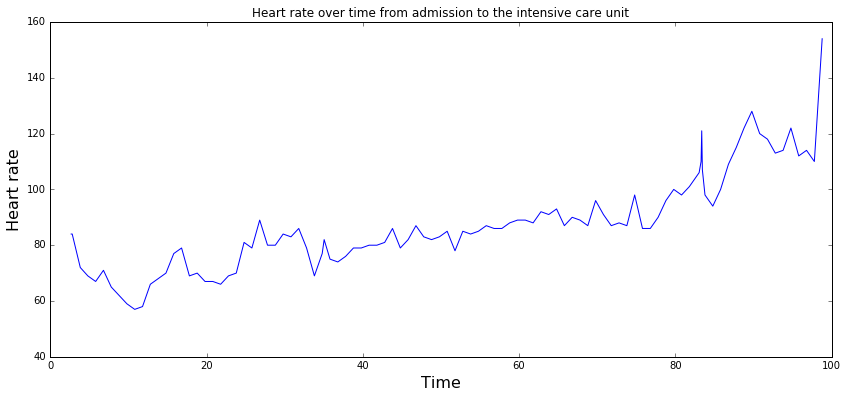

In [24]:
# Set x equal to the times
x_hr = ce.HOURS[ce.LABEL=='Heart Rate']

# Set y equal to the heart rates
y_hr = ce.VALUENUM[ce.LABEL=='Heart Rate']

# Plot time against heart rate
plt.figure(figsize=(14, 6))
plt.plot(x_hr,y_hr)


plt.xlabel('Time',fontsize=16)
plt.ylabel('Heart rate',fontsize=16)
plt.title('Heart rate over time from admission to the intensive care unit')

In [32]:
ce['LABEL'].unique()

array([u'PH (dipstick)', u'Specific Gravity (urine)',
       u'Temperature Fahrenheit', u'Heart Rate',
       u'Non Invasive Blood Pressure systolic',
       u'Non Invasive Blood Pressure diastolic',
       u'Non Invasive Blood Pressure mean', u'Heart rate Alarm - High',
       u'Heart Rate Alarm - Low', u'Respiratory Rate',
       u'O2 saturation pulseoxymetry',
       u'Non-Invasive Blood Pressure Alarm - High',
       u'Non-Invasive Blood Pressure Alarm - Low',
       u'O2 Saturation Pulseoxymetry Alarm - High',
       u'O2 Saturation Pulseoxymetry Alarm - Low', u'Resp Alarm - High',
       u'Resp Alarm - Low', u'SpO2 Desat Limit',
       u'Minute Volume Alarm - Low', u'Minute Volume Alarm - High',
       u'PEEP set', u'Inspired O2 Fraction', u'Paw High', u'Vti High',
       u'Fspn High', u'Apnea Interval', u'Daily Weight',
       u'Tidal Volume (set)', u'Tidal Volume (observed)', u'Minute Volume',
       u'Respiratory Rate (Set)', u'Respiratory Rate (spontaneous)',
       u'Respira

### Task 1

* What is happening to this patient's heart rate?
* Plot respiratory rate over time for the patient.
* Is there anything unusual about the patient's respiratory rate?


In [34]:
# Exercise 1 here



# What is happening to this patient's heart rate?

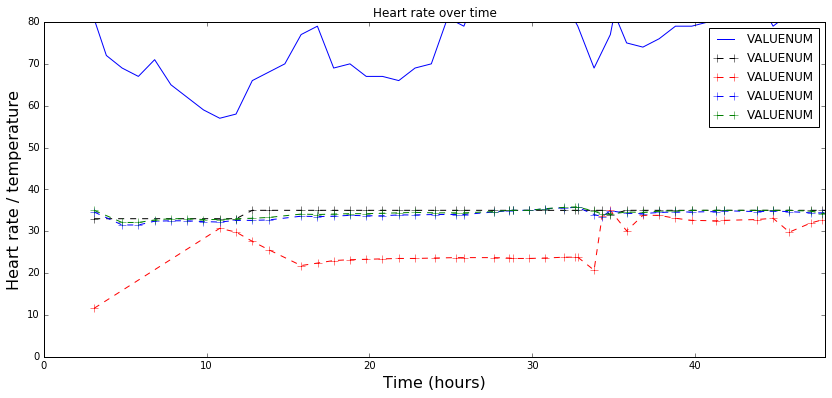

In [43]:
# Set x equal to the times
x_hr = ce.HOURS[ce.LABEL=='Heart Rate']

# Set y equal to the heart rates
y_hr = ce.VALUENUM[ce.LABEL=='Heart Rate']

# Plot time against heart rate
plt.figure(figsize=(14, 6))
plt.plot(x_hr,y_hr)

# Get some information regarding arctic sun
plt.plot(ce.HOURS[ce.LABEL=='Arctic Sun/Alsius Set Temp'], 
         ce.VALUENUM[ce.LABEL=='Arctic Sun/Alsius Set Temp'],
         'k+--',markersize=8)
plt.plot(ce.HOURS[ce.LABEL=='Arctic Sun Water Temp'], 
         ce.VALUENUM[ce.LABEL=='Arctic Sun Water Temp'],
         'r+--',markersize=8)
plt.plot(ce.HOURS[ce.LABEL=='Arctic Sun/Alsius Temp #1 C'], 
         ce.VALUENUM[ce.LABEL=='Arctic Sun/Alsius Temp #1 C'],
         'b+--',markersize=8)
plt.plot(ce.HOURS[ce.LABEL=='Arctic Sun/Alsius Temp #2 C'], 
         ce.VALUENUM[ce.LABEL=='Arctic Sun/Alsius Temp #2 C'],
         'g+--',markersize=8)

plt.xlabel('Time',fontsize=16)
plt.ylabel('Heart rate',fontsize=16)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Heart rate / temperature',fontsize=16)
plt.title('Heart rate over time')
plt.ylim(0,80)
plt.xlim(0,48)
plt.legend()

### Plot 2: Did the patient's vital signs breach any alarm thresholds?

- Alarm systems in the intensive care unit are commonly based on high and low thresholds defined by the carer.
- False alarms are often a problem and so thresholds may be set arbitrarily to reduce alarms.
- As a result, alarm settings carry limited information.

(0, 55)

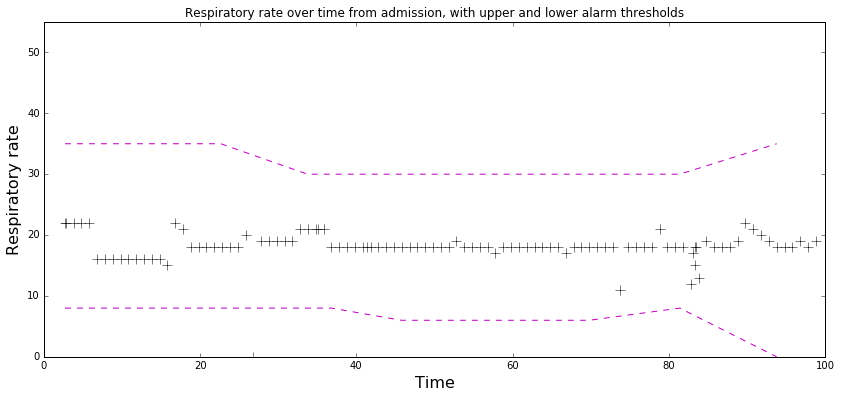

In [33]:
plt.figure(figsize=(14, 6))

plt.plot(ce.HOURS[ce.LABEL=='Respiratory Rate'], 
         ce.VALUENUM[ce.LABEL=='Respiratory Rate'],
         'k+', markersize=10, linewidth=4)

plt.plot(ce.HOURS[ce.LABEL=='Resp Alarm - High'], 
         ce.VALUENUM[ce.LABEL=='Resp Alarm - High'],
         'm--')

plt.plot(ce.HOURS[ce.LABEL=='Resp Alarm - Low'], 
         ce.VALUENUM[ce.LABEL=='Resp Alarm - Low'],
         'm--')

plt.xlabel('Time',fontsize=16)
plt.ylabel('Respiratory rate',fontsize=16)
plt.title('Respiratory rate over time from admission, with upper and lower alarm thresholds')
plt.ylim(0,55)


### Task 2

- Based on the data, does it look like the alarms would have triggered for this patient?


### Plot 3: What is patient's level of consciousness?

- Glasgow Coma Scale (GCS) is a measure of consciousness.
- It is commonly used for monitoring patients in the intensive care unit. 
- It consists of three components: eye response; verbal response; motor response.

In [16]:
# Display the first few rows of the GCS eye response data
ce[ce.LABEL=='GCS - Eye Opening'].head()

,ICUSTAY_ID,HOURS,LABEL,VALUE,VALUENUM,UOM
22,285485,1.753333,GCS - Eye Opening,Spontaneously,4,
47,285485,4.186667,GCS - Eye Opening,Spontaneously,4,
103,285485,8.186667,GCS - Eye Opening,Spontaneously,4,
118,285485,12.186667,GCS - Eye Opening,Spontaneously,4,
155,285485,16.186667,GCS - Eye Opening,Spontaneously,4,


(10, 165)

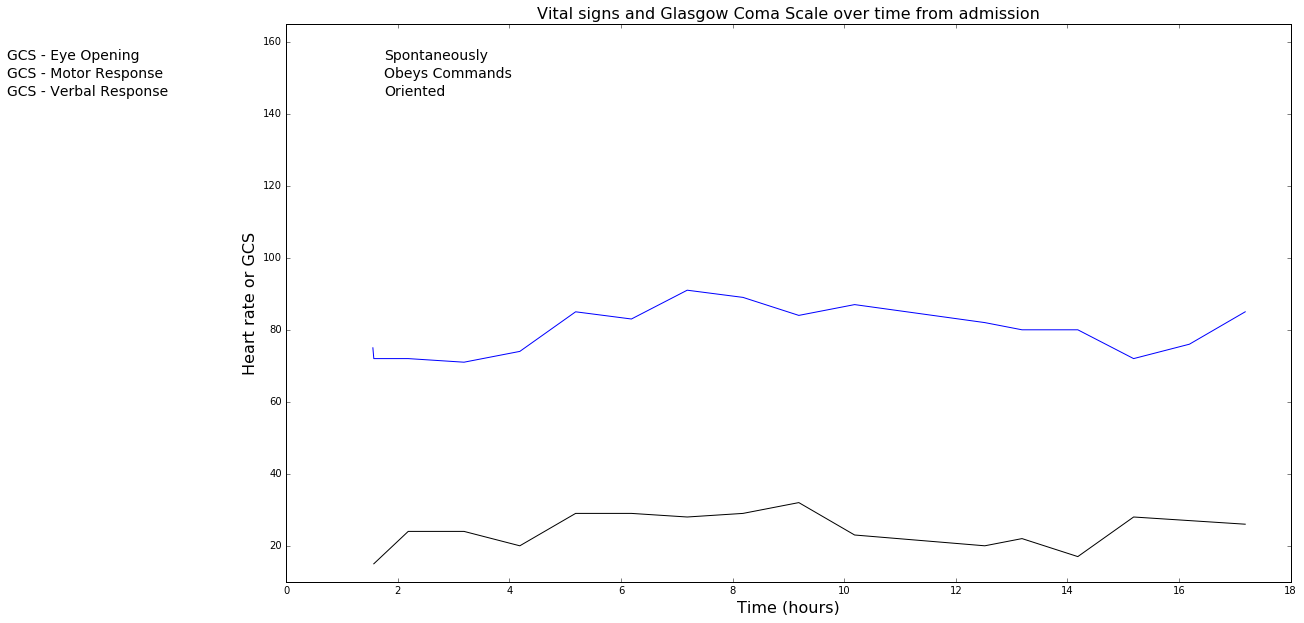

In [18]:
# Prepare the size of the figure
plt.figure(figsize=(18, 10))

# Set x equal to the times
x_hr = ce.HOURS[ce.LABEL=='Heart Rate']

# Set y equal to the heart rates
y_hr = ce.VALUENUM[ce.LABEL=='Heart Rate']


plt.plot(x_hr,y_hr)

plt.plot(ce.HOURS[ce.LABEL=='Respiratory Rate'], 
         ce.VALUENUM[ce.LABEL=='Respiratory Rate'],
         'k', markersize=6)

# Add a text label to the y-axis
plt.text(-5,155,'GCS - Eye Opening',fontsize=14)
plt.text(-5,150,'GCS - Motor Response',fontsize=14)
plt.text(-5,145,'GCS - Verbal Response',fontsize=14)   

# Iterate over list of GCS labels, plotting around 1 in 10 to avoid overlap
for i, txt in enumerate(ce.VALUE[ce.LABEL=='GCS - Eye Opening'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.HOURS[ce.LABEL=='GCS - Eye Opening'].values[i],155),fontsize=14)
        
for i, txt in enumerate(ce.VALUE[ce.LABEL=='GCS - Motor Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.HOURS[ce.LABEL=='GCS - Motor Response'].values[i],150),fontsize=14)

for i, txt in enumerate(ce.VALUE[ce.LABEL=='GCS - Verbal Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (ce.HOURS[ce.LABEL=='GCS - Verbal Response'].values[i],145),fontsize=14)

plt.title('Vital signs and Glasgow Coma Scale over time from admission',fontsize=16)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Heart rate or GCS',fontsize=16)
plt.ylim(10,165)


### Task 3

- How is the patient's consciousness changing over time?

# Stop here...

### Plot 2: What other data do we have on the patient?

- Using Pandas 'read_csv function' again, we'll now load the outputevents data - this table contains all information about patient outputs (urine output, drains, dialysis).

In [16]:
# OPTION 1: load outputs from the patient
query = """
select de.icustay_id
  , (strftime('%s',de.charttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS
  , di.label
  , de.value
  , de.valueuom
from outputevents de 
inner join icustays ie
  on de.icustay_id = ie.icustay_id
inner join d_items di
  on de.itemid = di.itemid
where de.subject_id = 40084
order by charttime;
"""

oe = pd.read_sql_query(query,conn)

In [17]:
oe.head()

,ICUSTAY_ID,HOURS,LABEL,VALUE,VALUEUOM
0,252522,0.753889,Pre-Admission,60,mL
1,252522,3.570556,Foley,80,mL
2,252522,4.270556,Foley,60,mL
3,252522,5.270556,Foley,60,mL
4,252522,6.270556,Foley,60,mL


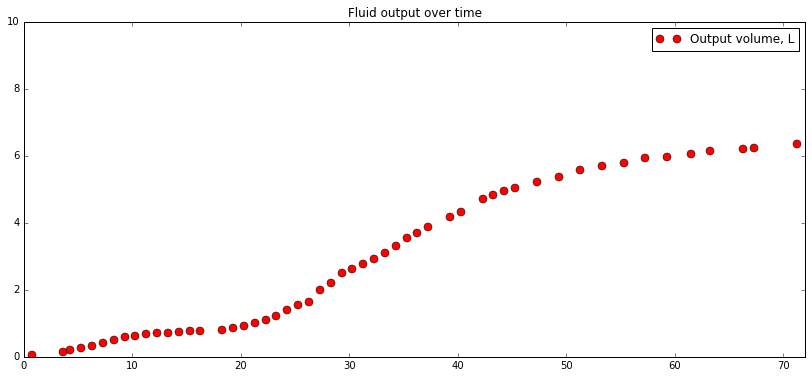

In [18]:
plt.figure(figsize=(14, 10))

plt.figure(figsize=(14, 6))
plt.title('Fluid output over time')

plt.plot(oe.HOURS, 
         oe.VALUE.cumsum()/1000, 
         'ro', markersize=8, label='Output volume, L')

plt.xlim(0,72)
plt.ylim(0,10)
plt.legend()

To provide necessary context to this plot, it would help to include patient input data. This provides the necessary context to determine a patient's fluid balance - a key indicator in patient health.

In [19]:
# OPTION 1: load inputs given to the patient (usually intravenously) using the database connection
query = """
select de.icustay_id
  , (strftime('%s',de.starttime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS_START
  , (strftime('%s',de.endtime)-strftime('%s',ie.intime))/60.0/60.0 as HOURS_END
  , de.linkorderid
  , di.label
  , de.amount
  , de.amountuom
  , de.rate
  , de.rateuom
from inputevents_mv de 
inner join icustays ie
  on de.icustay_id = ie.icustay_id
inner join d_items di
  on de.itemid = di.itemid
where de.subject_id = 40084
order by endtime;
"""

ie = pd.read_sql_query(query,conn)

# # OPTION 2: load ioevents using the CSV file with endtime as the index
# ioe = pd.read_csv('inputevents.csv'
#                   ,header=None
#                   ,names=['subject_id','itemid','label','starttime','endtime','amount','amountuom','rate','rateuom']
#                   ,parse_dates=True)

In [20]:
ie.head()

,ICUSTAY_ID,HOURS_START,HOURS_END,LINKORDERID,LABEL,AMOUNT,AMOUNTUOM,RATE,RATEUOM
0,252522,3.270556,3.287222,5635057,Gastric Meds,30.000000,mL,NaN,
1,252522,3.270556,3.287222,279061,Lansoprazole (Prevacid),1.000000,dose,NaN,
2,252522,0.753889,5.253889,4337240,NaCl 0.9%,45.000001,mL,10,mL/hour
3,252522,7.270556,7.287222,775255,Free Water,300.000000,mL,NaN,
4,252522,3.770556,9.770556,8221764,Nutren 2.0 (Full),60.000001,mL,10,mL/hour


Note that the column headers are different: we have "HOURS_START" and "HOURS_END". This is because inputs are administered over a fixed period of time.

In [21]:
ie['LABEL'].unique()

array([u'Gastric Meds', u'Lansoprazole (Prevacid)', u'NaCl 0.9%',
       u'Free Water', u'Nutren 2.0 (Full)', u'Furosemide (Lasix)',
       u'Dextrose 5%', u'Norepinephrine', u'Insulin - Humalog',
       u'Metoprolol', u'Metronidazole', u'PO Intake', u'GT Flush',
       u'Morphine Sulfate'], dtype=object)

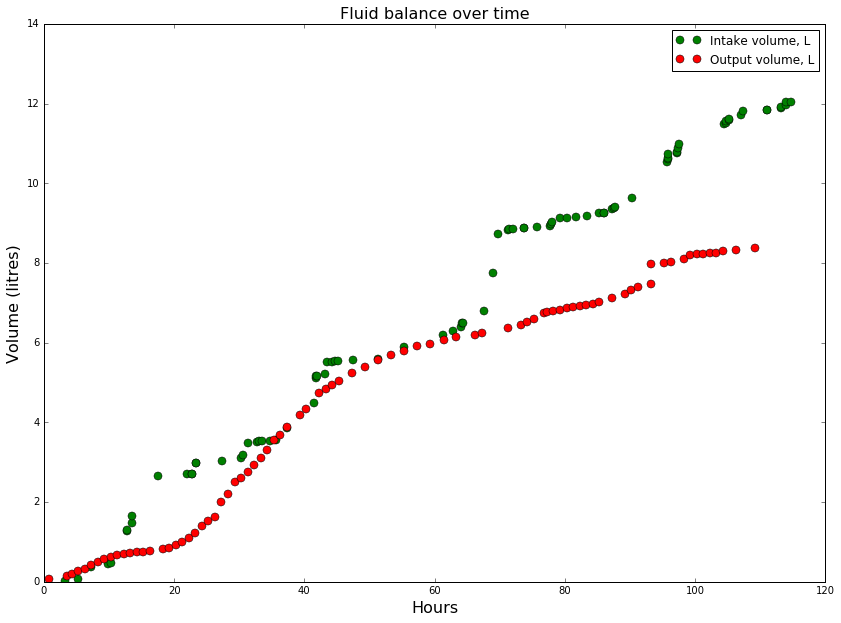

In [22]:
plt.figure(figsize=(14, 10))

# Plot the cumulative input against the cumulative output
plt.plot(ie.HOURS_END[ie.AMOUNTUOM=='mL'], 
         ie.AMOUNT[ie.AMOUNTUOM=='mL'].cumsum()/1000, 
         'go', markersize=8, label='Intake volume, L')

plt.plot(oe.HOURS, 
         oe.VALUE.cumsum()/1000, 
         'ro', markersize=8, label='Output volume, L')

plt.title('Fluid balance over time',fontsize=16)
plt.xlabel('Hours',fontsize=16)
plt.ylabel('Volume (litres)',fontsize=16)
# plt.ylim(0,38)
plt.legend()

As the plot shows, the patient's intake tends to be above their output (as one would expect!) - but there are periods where they are almost one to one. One of the biggest challenges of working with ICU data is that context is everything - let's look at a treatment (lasix) that we know will affect this graph.

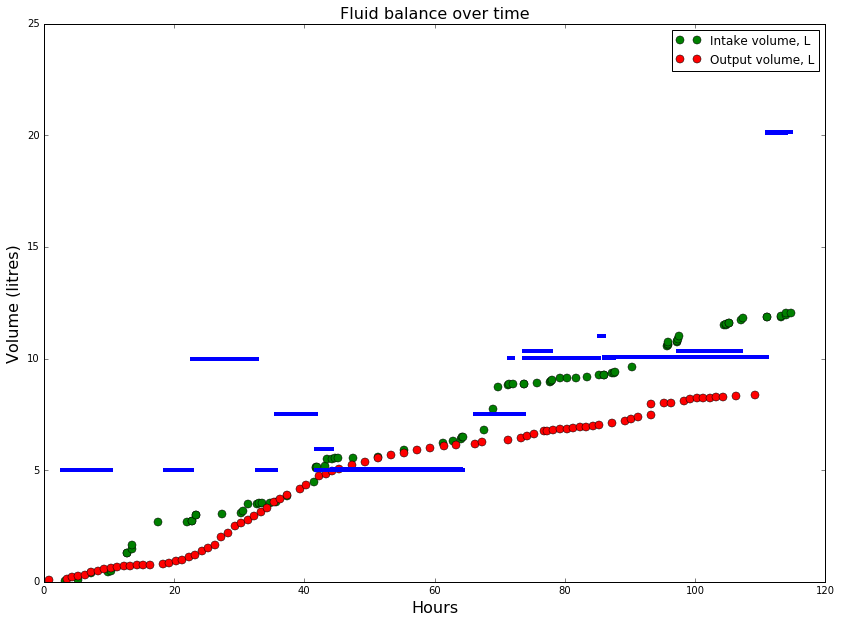

In [26]:
plt.figure(figsize=(14, 10))

# Plot the cumulative input against the cumulative output
plt.plot(ie.HOURS_END[ie.AMOUNTUOM=='mL'], 
         ie.AMOUNT[ie.AMOUNTUOM=='mL'].cumsum()/1000, 
         'go', markersize=8, label='Intake volume, L')

plt.plot(oe.HOURS, 
         oe.VALUE.cumsum()/1000, 
         'ro', markersize=8, label='Output volume, L')

# example on getting two columns from a dataframe: ie[['HOURS_START','HOURS_END']].head()

for i, idx in enumerate(ie.index[ie.LABEL=='Furosemide (Lasix)']):
    plt.plot([ie.HOURS_START[ie.LABEL=='Furosemide (Lasix)'][idx],
             ie.HOURS_END[ie.LABEL=='Furosemide (Lasix)'][idx]],
            [ie.RATE[ie.LABEL=='Furosemide (Lasix)'][idx],
             ie.RATE[ie.LABEL=='Furosemide (Lasix)'][idx]],
            'b-',linewidth=4)
    

plt.title('Fluid balance over time',fontsize=16)
plt.xlabel('Hours',fontsize=16)
plt.ylabel('Volume (litres)',fontsize=16)
# plt.ylim(0,38)
plt.legend()


In [52]:
ie['LABEL'].unique()

array([u'Gastric Meds', u'Lansoprazole (Prevacid)', u'NaCl 0.9%',
       u'Free Water', u'Nutren 2.0 (Full)', u'Furosemide (Lasix)',
       u'Dextrose 5%', u'Norepinephrine', u'Insulin - Humalog',
       u'Metoprolol', u'Metronidazole', u'PO Intake', u'GT Flush',
       u'Morphine Sulfate'], dtype=object)

### Exercise 2

* Plot the alarms for the mean arterial pressure ('```Arterial Blood Pressure mean```')
* HINT: you can use ```ce.LABEL.unique()``` to find a list of variable names
* Were the alarm thresholds breached?

In [ ]:
# Exercise 2 here




### Plot 3: Were the patient's other vital signs stable?

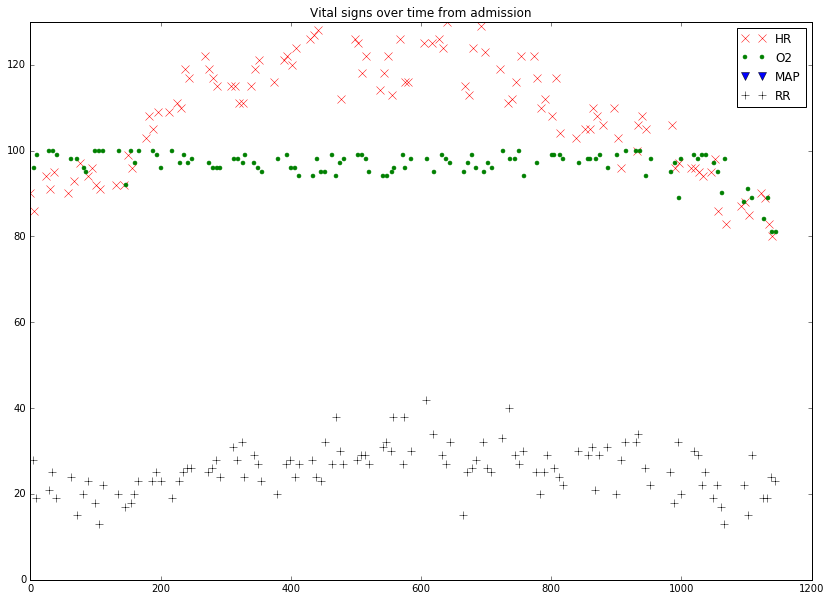

In [28]:
plt.figure(figsize=(14, 10))

plt.plot(ce.index[ce.LABEL=='Heart Rate'], 
         ce.VALUENUM[ce.LABEL=='Heart Rate'],
         'rx', markersize=8, label='HR')

plt.plot(ce.index[ce.LABEL=='O2 saturation pulseoxymetry'], 
         ce.VALUENUM[ce.LABEL=='O2 saturation pulseoxymetry'], 
         'g.', markersize=8, label='O2')

plt.plot(ce.index[ce.LABEL=='Arterial Blood Pressure mean'], 
         ce.VALUENUM[ce.LABEL=='Arterial Blood Pressure mean'], 
         'bv', markersize=8, label='MAP')

plt.plot(ce.index[ce.LABEL=='Respiratory Rate'], 
         ce.VALUENUM[ce.LABEL=='Respiratory Rate'], 
         'k+', markersize=8, label='RR')

plt.title('Vital signs over time from admission')
plt.ylim(0,130)
plt.legend()

### Plot 5: Laboratory measurements

Using Pandas 'read_csv function' again, we'll now load the labevents data.
This data corresponds to measurements made in a laboratory - usually on a sample of patient blood. 

In [1]:
# OPTION 1: load labevents data using the database connection
query = """
SELECT de.subject_id
  , de.charttime
  , di.label, de.value, de.valuenum
  , de.uom
FROM labevents de
INNER JOIN d_labitems di
  ON de.itemid = di.itemid
where de.subject_id = 40084
"""

le = pd.read_sql_query(query,conn)

# OPTION 2: load labevents from the CSV file
# le = pd.read_csv('data/example_labevents.csv', index_col='HOURSSINCEADMISSION')

NameError: name 'pd' is not defined

In [46]:
# preview the labevents data
le.head()

,SUBJECT_ID,CHARTTIME,LABEL,VALUE,VALUENUM,UOM
0,40080,2106-05-31 13:18:00,ALANINE AMINOTRANSFERASE (ALT),10,10.0,IU/L
1,40080,2106-05-31 13:18:00,ALBUMIN,2.5,2.5,g/dL
2,40080,2106-05-31 13:18:00,ALKALINE PHOSPHATASE,126,126.0,IU/L
3,40080,2106-05-31 13:18:00,ANION GAP,12,12.0,mEq/L
4,40080,2106-05-31 13:18:00,ASPARATE AMINOTRANSFERASE (AST),28,28.0,IU/L


In [42]:
# preview the ioevents data
le[le.LABEL=='HEMOGLOBIN']

,SUBJECT_ID,CHARTTIME,LABEL,VALUE,UOM
23,40080,2106-05-31 13:18:00,HEMOGLOBIN,9.1,g/dL
40,40080,2106-06-02 03:31:00,HEMOGLOBIN,8.8,g/dL
71,40080,2106-06-03 03:36:00,HEMOGLOBIN,8.2,g/dL
105,40080,2106-06-04 03:43:00,HEMOGLOBIN,8.2,g/dL
150,40080,2106-06-01 03:38:00,HEMOGLOBIN,8.3,g/dL
214,40080,2106-06-05 04:57:00,HEMOGLOBIN,8.5,g/dL


In [2]:
plt.figure(figsize=(14, 10))

plt.plot(le.index[le.LABEL=='HEMATOCRIT'], 
         le.VALUENUM[le.LABEL=='HEMATOCRIT'], 
         'go', markersize=6, label='Haematocrit')

plt.plot(le.index[le.LABEL=='HEMOGLOBIN'], 
         le.VALUENUM[le.LABEL=='HEMOGLOBIN'], 
         'bv', markersize=8, label='Hemoglobin')

plt.title('Laboratory measurements over time from admission')
plt.ylim(0,38)
plt.legend()

NameError: name 'plt' is not defined

## Plot 5: intravenous medications

- Using the Pandas 'read_csv function' again, we'll now load the the ioevents dataset

In [ ]:
# load ioevents
ioe = pd.read_csv('data/example_ioevents.csv',index_col='HOURSSINCEADMISSION_START')

In [ ]:
ioe.head()


In [ ]:
plt.figure(figsize=(14, 10))

plt.plot(ie.CHARTTIME[ie.LABEL=='Midazolam (Versed)'], 
         ie.RATE[ie.LABEL=='Midazolam (Versed)'], 
         'go', markersize=6, label='Midazolam (Versed)')

plt.plot(ie.CHARTTIME[ie.LABEL=='Propofol'], 
         ie.RATE[ie.LABEL=='Propofol'], 
         'bv', markersize=8, label='Propofol')

plt.plot(ie.CHARTTIME[ie.LABEL=='Fentanyl'], 
         ie.RATE[ie.LABEL=='Fentanyl'], 
         'k+', markersize=8, label='Fentanyl')

plt.title('Inputs over time from admission')
plt.ylim(0,380)
plt.legend()